In [1308]:
%pip install pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [1309]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [1310]:
# read the dataset
df = pd.read_csv('./dataset/mxmh_survey_results.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    object 
 13  Frequ

# Data Cleansing

In [1311]:

# EDA: check the correlation of "Primary streaming service" (i.e. music channel) and "Music effects" (i.e. mental health status)
# if the correlation is weak, will drop the column
def musicChannel(df):
    
    df_cat = df.dropna(subset = ['Primary streaming service', 'Music effects']).copy()
    df_cat['Primary streaming service']=df_cat['Primary streaming service'].astype('category').cat.codes
    df_cat['Music effects']=df_cat['Music effects'].astype('category').cat.codes
    correlation_matrix = df_cat[['Primary streaming service', 'Music effects']].corr()
    print (correlation_matrix)
    
    ax = plt.axes()
    sns.heatmap(correlation_matrix, annot=True, ax=ax)
    ax.set_title('Correlation between Mental Health Effect and Music Channel')
    plt.xlabel('Effect on Mental Health')
    plt.ylabel('Music Channel')
    plt.show()


    # Further analysis of the relationship between EACH music channel and music effects
    ct = pd.crosstab(df['Primary streaming service'], df['Music effects'])

    plt.figure(figsize=(10, 6))
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Correlation bewtween Mental Health Effect and Music Channel')
    plt.xlabel('Effect on Mental Health')
    plt.ylabel('Music Channel')
    plt.tight_layout()
    plt.show()


    # Analyze by PERCENTAGE for each music channel
    channel_pct = ct.div(ct.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(channel_pct, annot=True, fmt='.1f', cmap='YlGnBu')
    ax.set_xlabel('Effect on Mental Health')
    ax.set_ylabel('Music Channel')
    ax.set_title('Correlation bewtween Mental Health Effect and Music Channel (Percentage)')
    plt.tight_layout()
    plt.show()


    df = df.drop('Primary streaming service', axis=1)
    return df
    

                           Primary streaming service  Music effects
Primary streaming service                   1.000000      -0.041277
Music effects                              -0.041277       1.000000


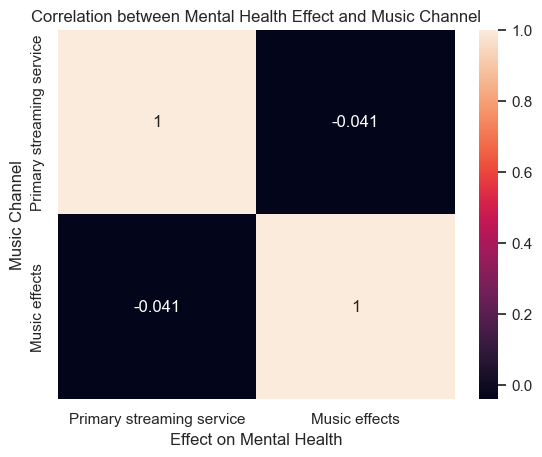

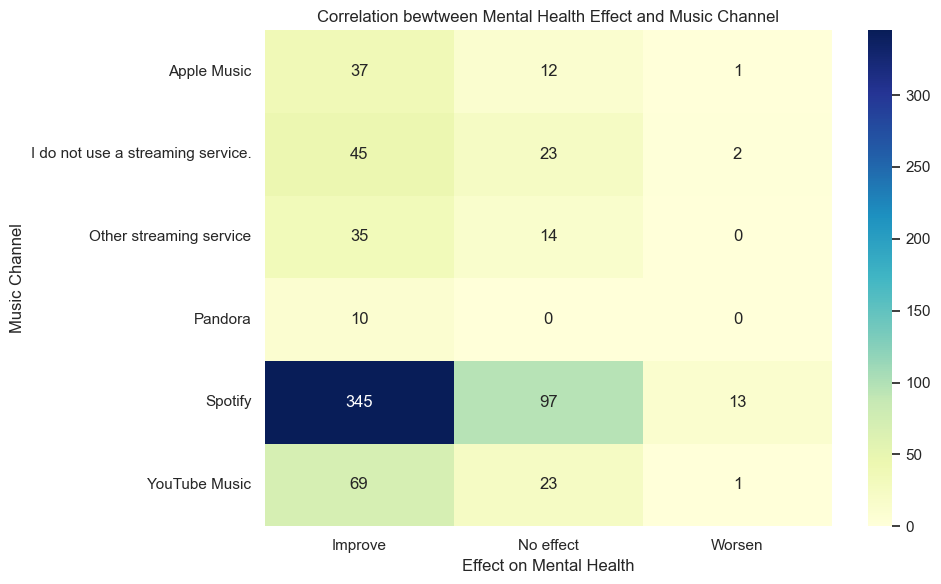

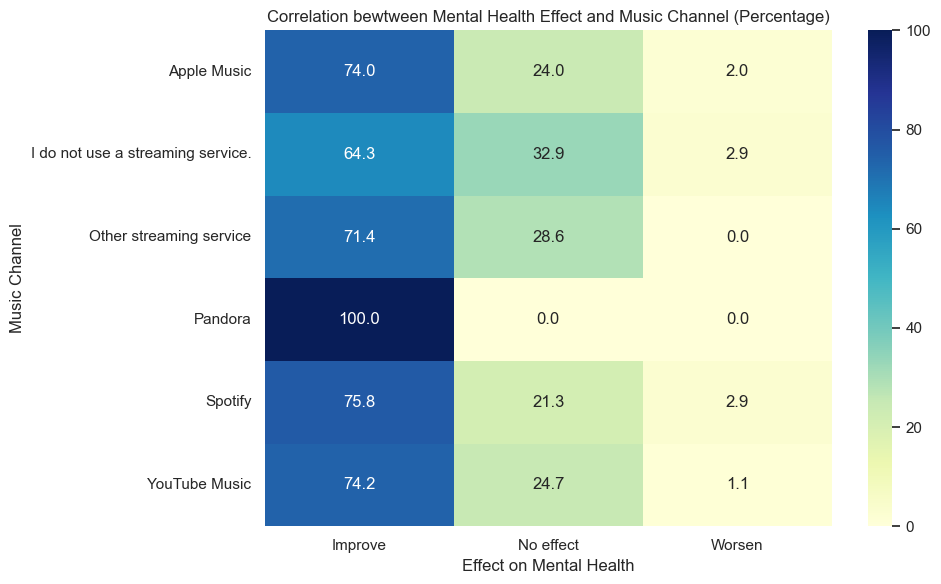

In [1312]:
df=musicChannel(df)

This function is to evaluate whether there is really relationship between Music Channel (col: Primary streaming service) and Mental Effect (col: Music effects).

From the 1st heatmap, it shows that the relationship is near zero.  It gives a preliminary sense that the two items have almost no relation.

The 2nd heatmap go further to check EACH channels and its Effect on mental status.  Most of the result shows not much relation, but Spotify.  However, this heatmap is based on the COUNT of use of channel.  It did NOT take the total use of channel into account.  Therefore it comes with the third heatmap.

The 3rd heatmap try to give a better distribution by presenting the PERCENTAGE of the Effect of each Channel, rather than only showing the count of use of Channel, in order to eliminate the the illusion caused by the popularity of Channel such as Spotify.  It shows that it has not much different on the effect by the choice of Channel.

However, the 3rd heatmap still has an defect.  Examining Pandora, it has 100% relation in Improvement of Mental Health.  Nevertheless, the sampling size of Pandora is the least (10 only).  Its representativeness is not significant.  It is therefore suggested to digest both the 2nd and 3rd heatmap when making conclusion.

Conclusion: we believe the correlation of Music Channel (col: Primary streaming service) and Mental Effect (col: Music effects) is insignificant.  It is decided to DROP the column from the dataset.

In [1313]:
# plot the distribution graph of bpm range
def plot_bpm_distribution(df):
    # drop null value from the 'BPM' column
    df_clean = df.dropna(subset = ['BPM']).copy()

    # find the max bpm value
    min_bpm = int(df['BPM'].min())
    max_bpm = int(df['BPM'].max())
    lower_threshold = 50
    upper_threshold = 200
    bin_size = 50
    bins = list(range(min(min_bpm, lower_threshold), upper_threshold, bin_size))
    bins.append(upper_threshold + 1)
    if (max_bpm > upper_threshold):
        bins.append(max_bpm + 1)
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
    
    # Create BPM range categories
    df_clean['BPM_Range'] = pd.cut(df_clean['BPM'], bins=bins, labels=labels, include_lowest=True)

    # Count occurrences in each range
    bpm_counts = df_clean['BPM_Range'].value_counts().sort_index()
    print(bpm_counts)

    # Create the plot
    bpm_counts.plot(kind='bar', xlabel='BPM Range', ylabel='Count', title='BPM Distribution of Favorite Music Genre')
    plt.figure(figsize=(6, 3))


BPM_Range
0-49               7
50-99            159
100-149          348
150-200          106
201-999999999      9
Name: count, dtype: int64


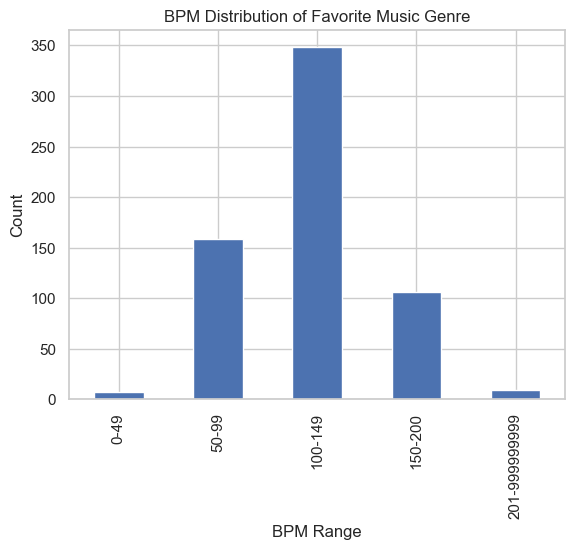

<Figure size 600x300 with 0 Axes>

In [1314]:
plot_bpm_distribution(df)

In general music literature, BPM (beats per minute) typically ranges from 50 to 200. Analysis of the dataset reveals that BPM values below 50 or above 200 are likely erroneous data points. Therefore, these rows should be excluded from the analysis.

In [1315]:
# drop the rows which the BPM value falls outside the usual range
df = df[~((df['BPM'] < 50) | (df['BPM'] > 200))]

In [1316]:
# Exclude columns that are unrelated to the focus of this analysis
df = df.drop(columns=['Timestamp', 'Age', 'While working', 'Exploratory', 'Foreign languages', 'Permissions'])

In [1317]:
list(df.columns[df.isnull().any()])

['Instrumentalist', 'Composer', 'BPM', 'Music effects']

Four columns contain null values, indicating that data cleansing is necessary.

In [1318]:
# drop rows that contain null value
df = df.dropna()

In [1319]:
df.shape

(605, 26)

Following the removal of missing or irrelevant data, the dataset used in this study comprises 605 rows and 26 columns.

# Exploratory Data Analysis

In [1320]:
# This function analyzes and visualizes the relationship between favorite genre and music effects
def genreXeffect(df):

    plt.figure(figsize=(12, 7))
    ax=sns.countplot(x='Fav genre', hue='Music effects', data=df)
    plt.xlabel('Favorite Genre')
    plt.ylabel('Count')
    ax.set_title('Music Effects by Favorite Genre')
    # plt.xticks(rotation=30)
    # plt.legend(title='Music effects')
    plt.tight_layout()
    plt.show()

    # Plot horizontal bars for better readability
    plt.figure(figsize=(12, 7))
    ax = sns.countplot(y='Fav genre', hue='Music effects', data=df)  # Changed x -> y for horizontal bars
    plt.ylabel('Favorite Genre')
    plt.xlabel('Count')
    ax.set_title('Mental Health Effect by Favorite Genre')
    plt.tight_layout()
    plt.show()



    # Sort in order of Genre with greatest Mental Improvement
    count_df = df.groupby(['Fav genre', 'Music effects']).size().reset_index(name='count')
    improve_counts = count_df[count_df['Music effects'] == 'Improve']
    genre_order = improve_counts.sort_values('count', ascending=False)['Fav genre'].tolist()

    pivot = count_df.pivot(index='Fav genre', columns='Music effects', values='count').fillna(0)
    pivot = pivot.loc[genre_order]

    plt.figure(figsize=(12, 7))
    ax = sns.countplot(
        y='Fav genre',
        hue='Music effects',
        data=df,
        order=genre_order,
        hue_order=['Improve', 'No effect', 'Worsen'],
        palette='Accent'
    )
    ax.set_title('Mental Health Effects by Favorite Genre')    
    plt.xlabel('Count')
    plt.ylabel('Favorite Genre')
    #plt.title('Music Effects by Favorite Genre')
    plt.legend(
        title='Music effects',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.tight_layout()
    plt.show()



    # Further analyze the effect of music in terms of percentage
    total_per_genre = count_df.groupby('Fav genre')['count'].transform('sum')
    count_df['percentage'] = count_df['count'] / total_per_genre * 100

    improve_mask = count_df['Music effects'] == 'Improve'
    improve_percent = count_df[improve_mask][['Fav genre', 'percentage']].set_index('Fav genre')
    sorted_genres = improve_percent['percentage'].sort_values(ascending=True).index.tolist()

    pivot = count_df.pivot(index='Fav genre', columns='Music effects', values='percentage').fillna(0)
    pivot = pivot.loc[sorted_genres]

    plt.figure(figsize=(12, 7))
    pivot.plot(kind='barh', stacked=True, colormap='Accent', width=0.8)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Favorite Genre')
    plt.title('Mental Health Effects by Favorite Genre')
    plt.legend(
        title='Music effects',
        bbox_to_anchor=(1.05, 1),  # (x, y) position: 1.05 moves it outside the right edge
        loc='upper left'
    )
    plt.tight_layout()
    plt.show()

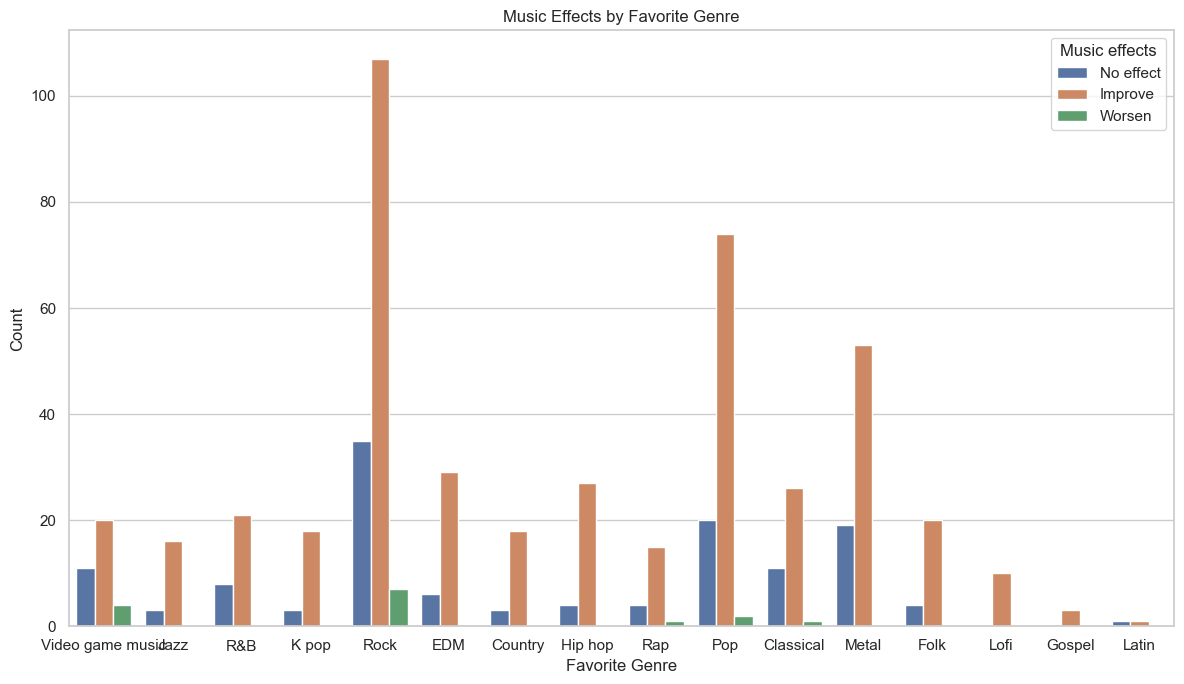

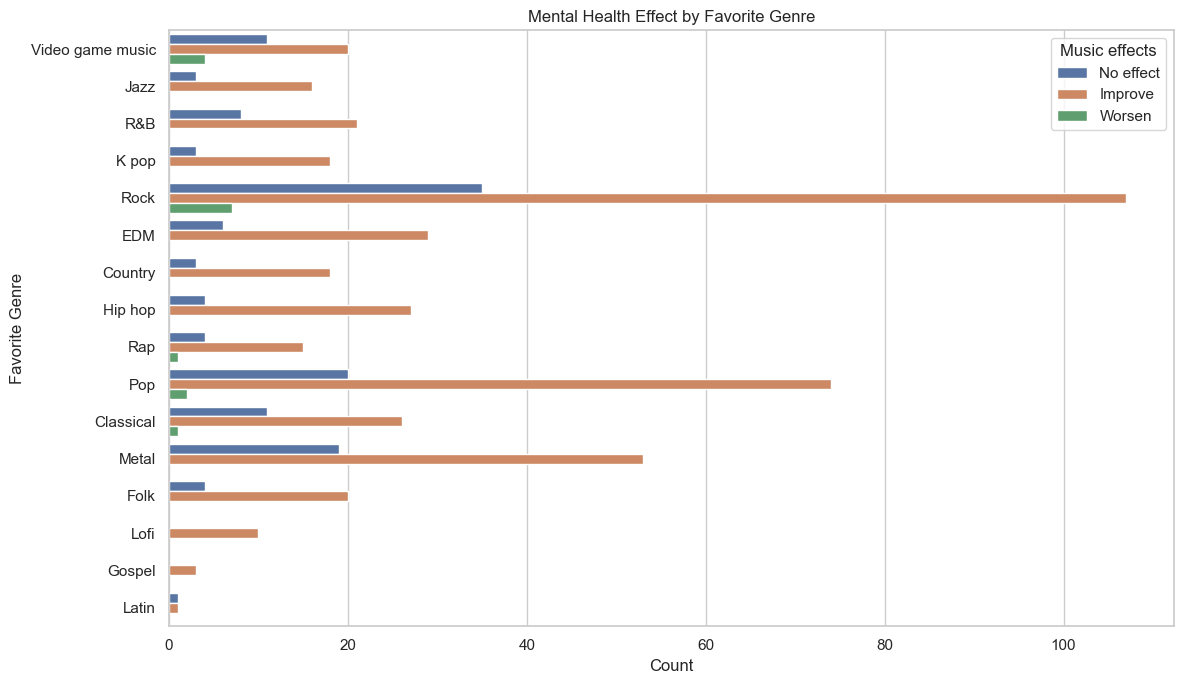

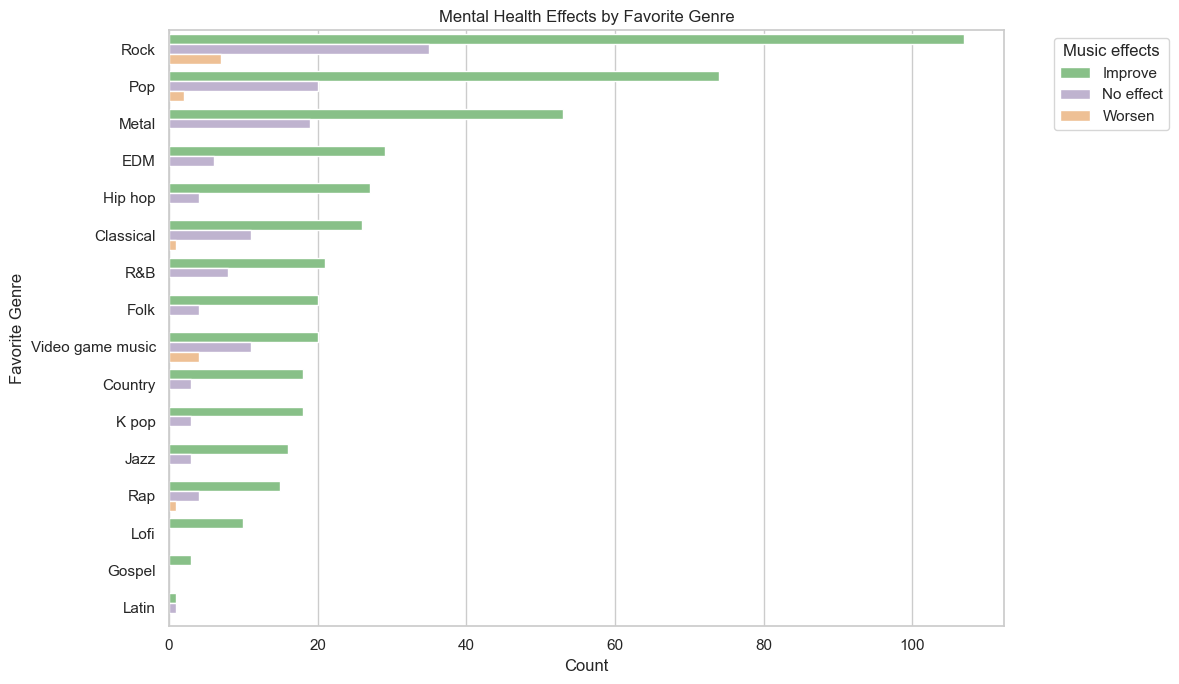

<Figure size 1200x700 with 0 Axes>

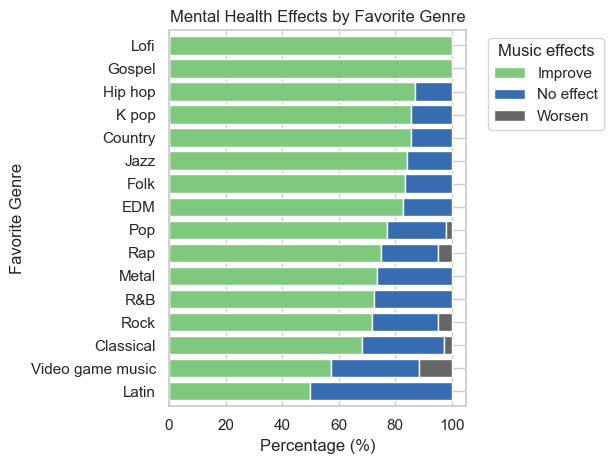

In [1321]:
genreXeffect(df)

Now it comes to analyze the relation between candidate's Favourite Genre (col: Fav genre) and its Mental Effect (col: Music effects).

The 1st bar chart and 2nd bar chart are basically the same, showing the popularity of Fav Genre and its Effect to the Mental Health.  The 2nd chart, with horizontal bar, is believed to be better presentation, to avoid word length mixing up or torting the words by rotation

The 3rd chart further improved by using better colours (green for Improve, violet for No effect and amber for Worsen) and sorting by count of Improvement to highlight the Effect of the Genre.

Nevertheless, the 3rd chart is based on the COUNT of the Fav Genre.  Take Rock as example, Rock has the longest bar in Improved Mental Health.  Does it mean Rock is the most effective genre to bring healthier Mental state?  Not necessarily, it may simply because Rock has the largest population of candidate choosing it as the Fav Genre.  Take a deeper look, it also has the largest count of No Effect and even Worsen result to the Mental Health.  Therefore, it leads to the need of the 4th chart.

The 4th chart, based on the 3rd, further investigage the Effect by compiling its PERCENTAGE.  It eliminates the illusion brought by the popularity of Genre, trying to show the true Effect of the Genre to the Mental Health.

Still, it has its defect and bias.  Since it eliminates the consideration of population (i.e. Count of Fav Genre choosed by candidate), it becomes the problem iself with the doubt on sampling size.  Take a look on Lofi, Gospel which gave 100% Improvement to Mental Health; whereas Latin brought the least (50%) Improvement.  Does it mean Lofi and Gospel is the best Genre while Latin is the most discouraing Genre for Mental Health?  No!  Look back on the 3rd chart, those 3 Genres has the least popularity and thus the sampling size to show the representativeness to draw a conclusion to its Effectinvess to candidates' Mental Health.

Conclusion: when analysing the Effect of Genre to Mental Health, it is recommended to examine both 3rd and 4th chart to prevent bias of popularity and sampling size.

In [1351]:
# analyze the correlation between different music genres and mental health effects
def analyze_music_genre_mental_health_relationship(df):
    # Get all frequency columns (music genres)
    music_genre_columns = [col for col in list(df.columns) if 'Frequency' in col]
    # Create a copy of the dataframe with only relevant columns
    df_new = df[[*music_genre_columns, 'Music effects']].copy()

    # Create subplot grid: 8 rows, 2 columns
    fig,axes = plt.subplots(8, 2, figsize=(8,16))
    row = 0
    col = 0
    
    # Iterate through each music genre
    for genre in music_genre_columns :
        # Map frequency categories to numeric values
        frequency_map = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very frequently': 3}
        df_new[genre] = df_new[genre].map(frequency_map)
        # Create crosstab: frequency vs mental health effects
        crosstab = pd.crosstab(index=df_new[genre], columns=df_new['Music effects'])

        # select the 'Sometimes' and 'Very frequently' rows
        sns.heatmap(crosstab[2:], annot=True, fmt='d', cmap='Blues',ax=axes[row][col], 
            yticklabels=['Sometimes', 'Very frequently'],
        )

        axes[row][col].set_title(f'{genre.replace('Frequency [', '').replace(']', '')} vs Mental Health Effects')
        axes[row][col].set_xlabel('Mental Health Effects')

        # Move to next position in grid
        col += 1
        if (col == 2):
            col = 0
            row += 1

    plt.tight_layout()
    plt.show()  

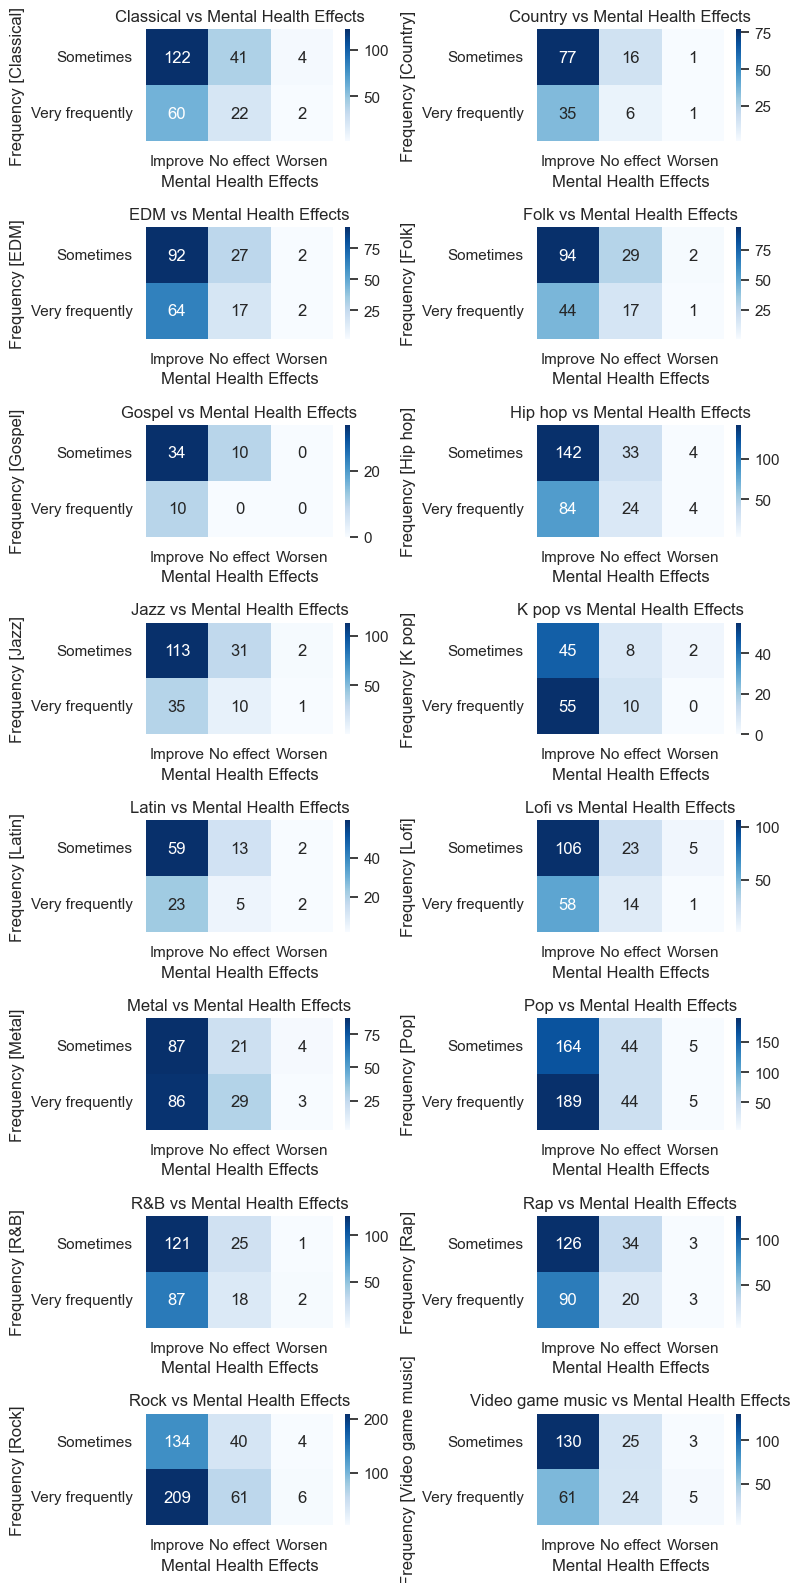

In [1352]:
analyze_music_genre_mental_health_relationship(df)

The heatmaps above illustrate the relationship between listening frequency for different music genres and their associated mental health effects. Note that the frequency categories 'Never' and 'Rarely' are excluded from this analysis due to insufficient data points.

Based on the heatmap analysis, Pop and Rock emerge as the most popular music genres among the 16 genres examined in the dataset. The majority of respondents report that listening to these genres improves their mental health, while only a small proportion indicate that these genres worsen their mental well-being.

The analysis reveals that K-pop, Pop, and Metal demonstrate the most positive impact on mental health outcomes compared to other genres in the dataset. This suggests that these genres may have particularly beneficial effects on listeners' psychological well-being.

In [1324]:
# This function analyzes and visualizes the relationship between hours of listening to music and its effects    
def hourXeffect (df):
    d = df.copy()

    d['Music effects'] = d['Music effects'].astype('category')
    plt.figure(figsize=(10, 6))
    ax=sns.boxplot(x='Music effects', y='Hours per day', data=df)
    plt.xlabel('Effect on Mental Health')
    plt.ylabel('Hours of music playing per day')
    plt.ylim(top=24)
    ax.set_title('Relationship between Hours of Music Playing and Mental Effects')
    # plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Calculate mean hours per day and analyze its effect on mental health
    mean_hours = d.groupby('Music effects')['Hours per day'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    ax=sns.barplot(x='Music effects', y='Hours per day', data=mean_hours)
    plt.xlabel('Effect on Mental Health')
    plt.ylabel('Average Hours of music playing per Day')
    # plt.title('Average Hours per Day by Music Effects')
    ax.set_title('Relationship between Average Hours of Music Playing and Mental Effects')
    # plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


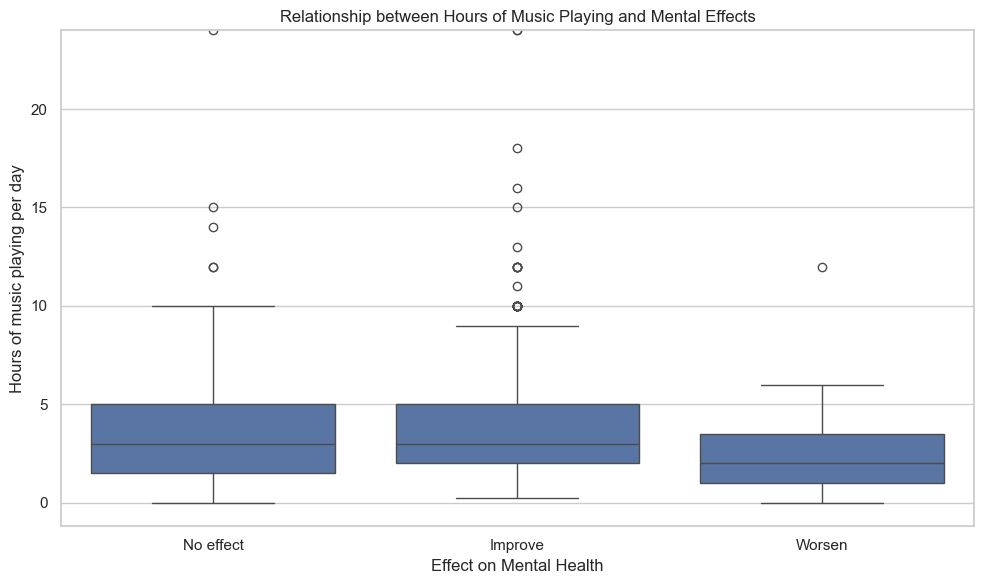

/var/folders/dy/mwlzchhj2037xv4b4fd8zpg40000gn/T/ipykernel_13134/3161988012.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_hours = d.groupby('Music effects')['Hours per day'].mean().reset_index()


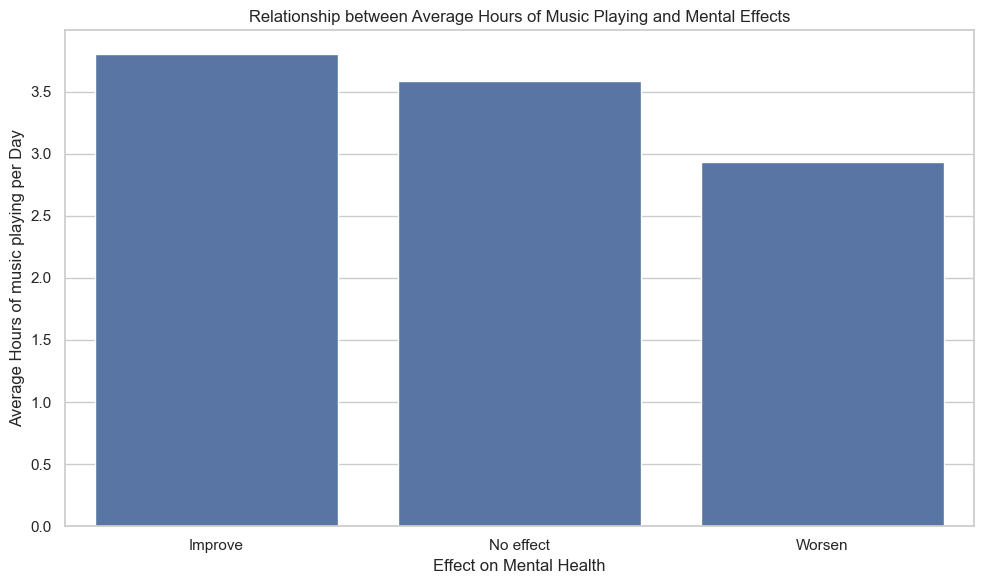

In [1325]:
hourXeffect(df)

Now it tries to analyze the relationship between the duration (col: Hours) of Music Playing and its Mental Effect (col: Music effects).

The boxplot shows the distribution of Hours/day of music playing for candidates of different Mental Effect.

To make a clearer oberservation, AVERAGE hours is calculated of each Mental Effect.

Observation: Note that it is NOT a conclusion but observation.  It is observed that candidates with Improved Mental status listened to music for around 3.5 Hours/day in average.  However, it does not mean it is a staggering or linear effect that listening less than 3.5 Hours will elicit No Effect.  Even, it shows NO causal relation that music playing less than 3 hours will cause Worsen Mental Health.  Further and wider analysis together with other attributes are required to draw a clearer conclusion.

In [1326]:
# This function analyzes and visualizes the relationship between hours of listening to music and mental health symptoms
def hours_symptoms_relationship(df):

    Mental_Health_Symptoms = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
    bins = list(range(0, 26, 2))
    hours_labels = [f'{i}-{i+2}' for i in range(0, 24, 2)]

    df['Hours_Group'] = pd.cut(df['Hours per day'], bins=bins, labels=hours_labels, right=False)

    # Melt the dataframe to long format for seaborn plotting
    df_melted = df.melt(id_vars=['Hours_Group'], value_vars = Mental_Health_Symptoms,
                        var_name='Mental_Health_Type', value_name='Ranking')

    plt.figure(figsize=(14, 7))
    sns.set_theme(style="whitegrid")

    # Plot a Boxplot with hours groups on x axis, ranking on y axis, hue by mental health type
    sns.boxplot(x='Hours_Group', y='Ranking', hue='Mental_Health_Type',
                data=df_melted, palette='Set2')

    plt.xticks(rotation=45)
    plt.xlabel('Hours of Music Listening Per Day')
    plt.ylabel('Mental Health Symptoms Ranking (0-10)')
    plt.title('Distribution of Mental Health Symptoms Rankings by Music Listening Time')
    plt.legend(title='Mental Health Symptoms', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    

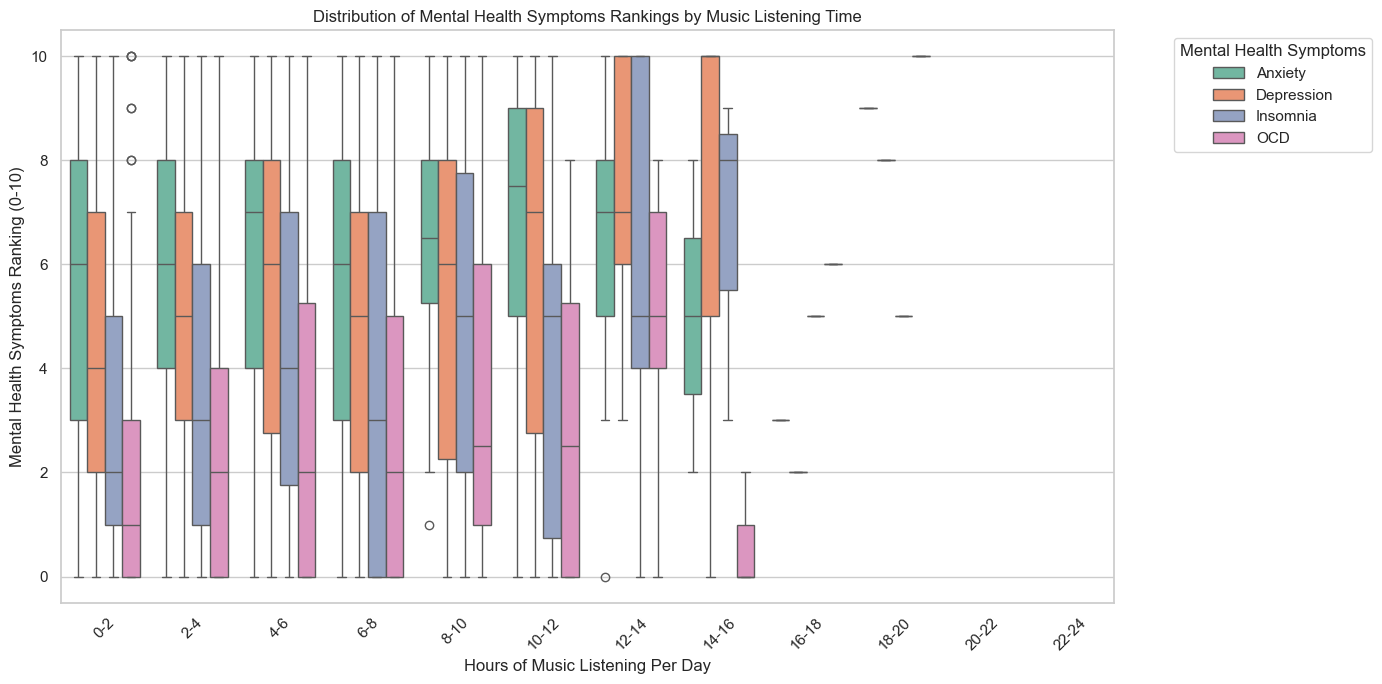

In [1327]:
hours_symptoms_relationship(df)

In [1328]:
# Further visualize the boxplot by creating subplots, split by 4 conditions for clearer insight into each.
def hours_symptoms_subplot(df):
    metrics = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
    bins = list(range(0, 26, 2))
    bin_labels = [f'{i}-{i+2}' for i in range(0, 24, 2)]

    df['Hours_Group'] = pd.cut(df['Hours per day'], bins=bins, labels=bin_labels, right=False)

    def plot_metric(ax, metric):
        data = [df[df['Hours_Group'] == h][metric].dropna() for h in bin_labels]
        ax.boxplot(data, positions=range(len(bin_labels)))
        ax.set_title(metric)
        ax.set_xticks(range(len(bin_labels)))
        ax.set_xticklabels(bin_labels, rotation=45)
        if metric == metrics[0]:
            ax.set_ylabel('Ranking')

    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), sharey=True)
    if len(metrics) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        plot_metric(ax, metric)

    fig.suptitle('Distribution of Each Mental Health Ranking by Music Listening Time')
    plt.tight_layout()
    plt.show()

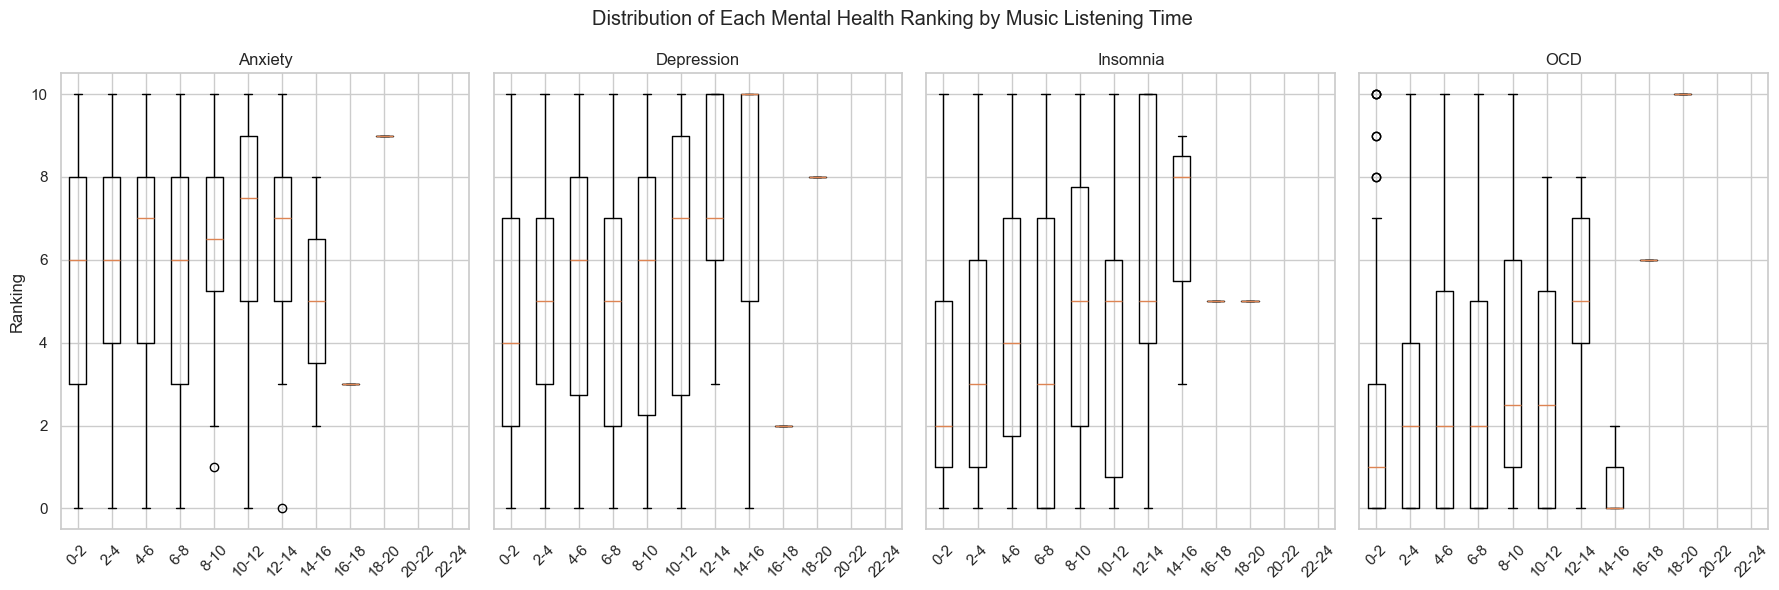

In [1329]:
hours_symptoms_subplot(df)

These boxplots show the relationship between mental health rankings (Anxiety, Depression, Insomnia, OCD) and the hours of music listening per day.

Observation for each mental health symptoms:

For both Anxiety & Depression, the medians are higher and consistently increase between 6 to 14 hours/day, peaking between 10–14 hours.it suggests a positive correlation between more music listening and higher anxiety symptoms.For Insomnia, there's steady rise in symptoms with more music; 14–16 hrs/day group shows the highest median score, indicating most severe insomnia in this group.For OCD, the number starts off low and gradually increases, but remains lower overall and less significant when compared to the other conditions. The trend levels off or becomes inconsistent beyond 16 hours/day, likely due to smaller sample sizes and outliers.

Overall Observation:

There is a positive correlation between music listening time and severity of mental health symptoms across all four conditions. Extended music listening (6–14 hours/day) is consistently associated with increased mental health symptom severity. Lower music listening (0–4 hours/day) is associated with fewer symptoms, particularly for OCD and Insomnia. The peak mental health conditions observed in the 10–14 hours/day listening groups. OCD behaves differently, less sharply impacted by listening time, though increases are still present. For those very high listening durations (16+ hours), they contain fewer data points, and show inconsistent or extreme values.These are likely outliers or reflect unique, individual cases.

Conclusion:

These findings suggest a correlation that individuals struggling more with mental health may be using music as a coping mechanism, leading to higher listening times.

In [1330]:
def music_role_mapping(row):
    if row['Instrumentalist'] == 'No' and row['Composer'] == 'No':
        return 'Neither'
    elif row['Instrumentalist'] == 'Yes' and row['Composer'] == 'No':
        return 'Instrumentalist'
    elif row['Instrumentalist'] == 'No' and row['Composer'] == 'Yes':
        return 'Composer'
    else:
        return 'Both'


def analyze_music_role_mental_health_relationship(df):
    # drop columns with invalid values
    df_new = df[['Instrumentalist', 'Composer', 'Music effects']].copy()
    df_new = df_new.dropna(subset=['Instrumentalist', 'Composer','Music effects'])
    df_new['Instrumentalist Value'] = df_new['Instrumentalist'].astype('category').cat.codes
    df_new['Composer Value'] = df_new['Composer'].astype('category').cat.codes

    df_new['Music role'] = df_new.apply(music_role_mapping, axis=1)

    # Create a crosstab showing Music Effects for each role combination
    crosstab = pd.crosstab([df_new['Music role']], 
                          df_new['Music effects'], 
                          margins=True)

    # Create a heatmap of the crosstab (excluding the 'All' row and column)
    crosstab_plot = crosstab.iloc[:-1, :-1]  # Remove margins

    # Normalize to get ratios (proportions)
    ratio_table = crosstab_plot.div(crosstab_plot.sum(axis=1), axis=0)
    ratio_table['No effect/Improve'] = (ratio_table['No effect'] / ratio_table['Improve'])
    ratio_table['No effect/Worsen'] = (ratio_table['No effect'] / ratio_table['Worsen'])

    # Replace inf and -inf with '-'
    ratio_table.replace([np.inf, -np.inf], '-', inplace=True)

    # Print as ratios (rounded for clarity)
    print(ratio_table.round(3))

    plt.figure(figsize=(8,4))
    sns.heatmap(crosstab_plot, annot=True, fmt='d', cmap='Blues', xticklabels=['Improved', 'No effect', 'Worsen'])  
    plt.title('Music Roles vs Mental Health Effects') 
    plt.xlabel('Mental Health Effects') 
    plt.ylabel('Instrumentalist-Composer')
    plt.show()



Music effects    Improve  No effect  Worsen  No effect/Improve No effect/Worsen
Music role                                                                     
Both               0.812      0.162   0.025              0.200              6.5
Composer           0.920      0.080   0.000              0.087                -
Instrumentalist    0.822      0.161   0.017              0.196              9.5
Neither            0.715      0.257   0.029              0.359         8.909091


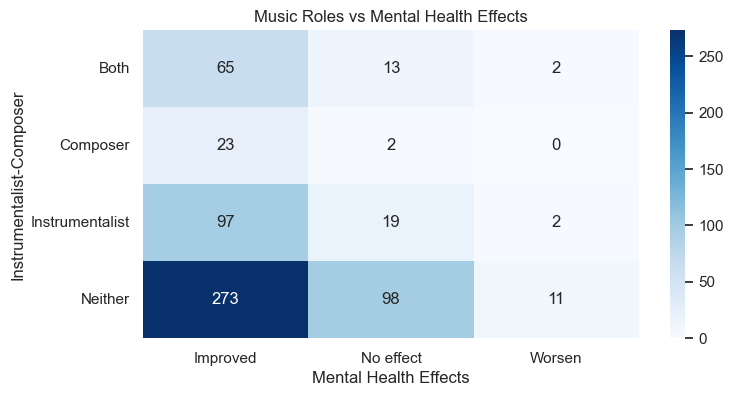

In [1331]:
analyze_music_role_mental_health_relationship(df)

The heatmap above illustrates the correlation between different music roles and mental health effects. Music roles are defined by four categories: instrumentalist, composer, both (instrumentalist and composer), and neither (pure music listener). 

The majority of respondents across all music roles report that music improves their mental health, while only a small proportion report the opposite effect. The ratio of music benefiting mental health to music having no impact on mental health is highest among pure music listeners, followed by those with both musical roles, then instrumentalists, and lowest among composers.